In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from utils.config import load_config
from utils.notebook import display_batch, imshow, image_from_tensor
from utils.masking import mask_batch
from ml.UNet import UNet
from ml.SimpleGenerator import SimpleGenerator

In [2]:
config = load_config("../config.toml")
image_size = config["files"]["image_size"]
batch_size = config["train"]["batch_size"]
workers = config["train"]["workers"]

dataroot = "../.images/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = ImageFolder(root=dataroot, transform=Compose([
    Resize((image_size, image_size)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [4]:
dl_iter = iter(dataloader)

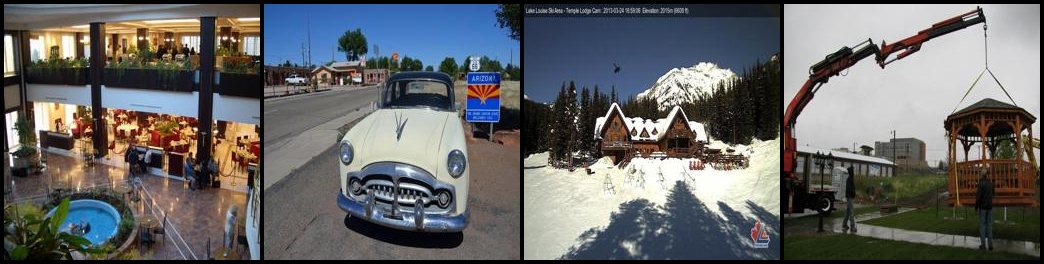

In [5]:
real_batch = next(dl_iter)
display_batch(real_batch)

In [6]:
MODEL_DIR = "../models"
D_CKPT = "discriminator_20260119_032229.pth"
G_CKPT = "generator_20260119_032229.pth"

In [7]:
def load_generator(checkpoint_path, model, device):
    G_weights = torch.load(f"{MODEL_DIR}/{checkpoint_path}")
    netG = model(device)
    netG.load_state_dict(G_weights)
    netG.to(device)
    return netG

In [8]:
def eval_generator(checkpoint_path, model, test_batch, device):
    test_mask = mask_batch(test_batch).to(device)
    netG = load_generator(checkpoint_path, model, device)
    with torch.no_grad():
        res = netG(test_mask)
        for i in range(batch_size):
            imshow(np.concatenate([image_from_tensor(test_mask[i]), image_from_tensor(res[i])], axis=1))

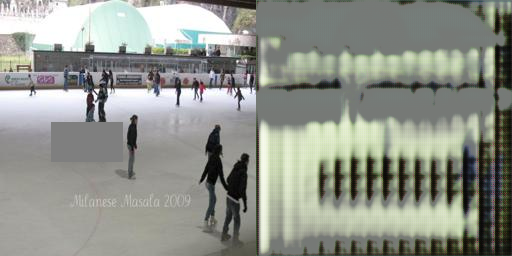

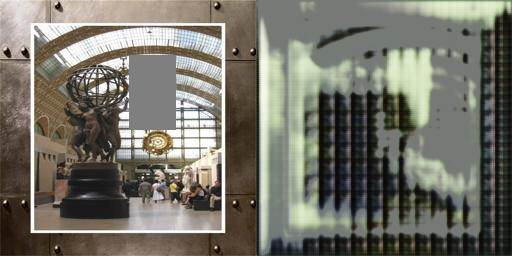

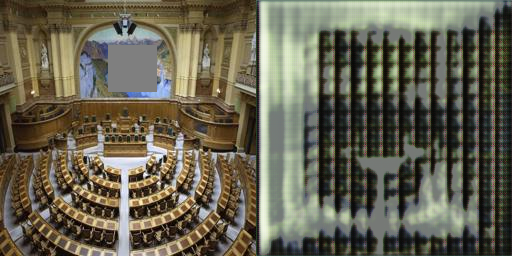

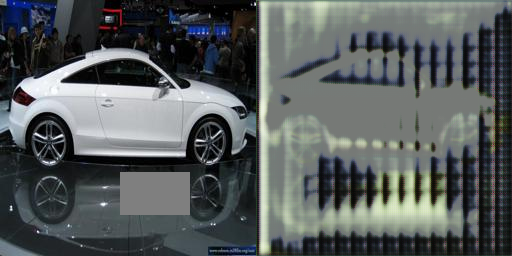

In [9]:
test_batch = next(dl_iter)

eval_generator(G_CKPT, UNet, test_batch[0], device)

## Best

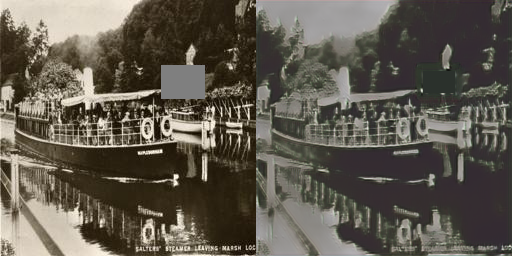

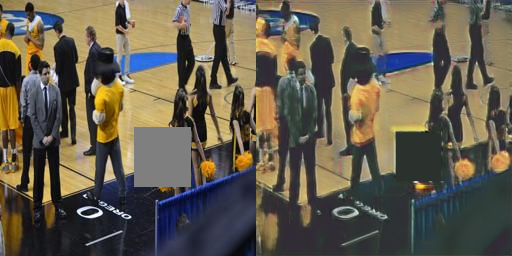

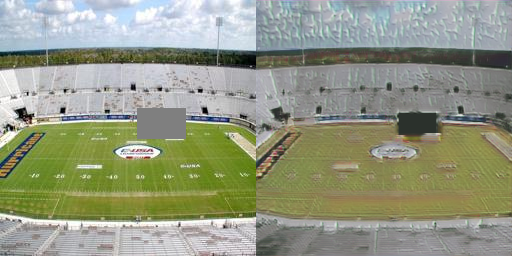

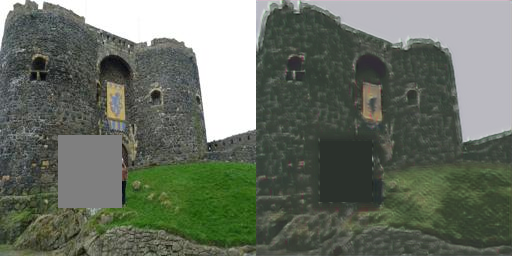

In [10]:
BEST_G_CKPT = "generator_best.pth"

test_batch = next(dl_iter)
eval_generator(BEST_G_CKPT, SimpleGenerator, test_batch[0], device)